# Automated pipeline for isotopic charge states in Mass spectrometry data

## 1. Project Overview


Understanding the interactions, dynamics and structure of the proteins provides a greater level of comprehension of how a protein works, allowing us to create hypotheses about how to affect it, control it, or modify it.

Mass Spectrometry has been a great analytical technique to study the proteome in the past years and provides a lot of information and data via Mass Spectrum results.

This project focuses on the charge states identification in Mass Spectrum fingerprints and the distinction between true peaks and background noise through an automatic pipeline development instead of a visual inspection. 
The algorithm currently searches for +2, +3 and +4 charge states and the results provide the user with the number of isotopic windows for each charge state in the selected dataset as well as creates .txt files that can be used as labelled training datasets for the creation of a deep learning artificial network.


## 2. Data

The data files used were provided by Dr. Thalassinos, in .txt file format. The data are a subset of an unpublished project and have been uploaded in PRIDE and held privately at the moment. 

The files contain Mass Spectra results in a Tabular form, composed of thousands of data points, corresponding to different m/z and their intensities. The Mass Spectra results are peptides or parts of peptides of different proteins and they were used for code testing and development.

First column: **m/z**

Second column: **intensity**


## 3. Exploratory Analysis 

In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
from matplotlib.patches import Rectangle
import seaborn as sns
import os
import shutil
sns.set()

Open the data file, create a dataframe and check the first 20 lines

In [2]:
my_list = []
mz_list = []
int_list = []
data = []
min_del = 0
charge_state = 0
with open('peptides_lcms.txt', mode="r") as f:
    my_list = f.read().splitlines()
    d = {}
    for i in my_list:
        (k, v) = i.split()
        d[k] = v   
        #mz_list.append(k)
        #int_list.append(v)
        data.append((float(k),float(d[k])))
 

columns = ['m/z', 'intensity']
df0 = pd.DataFrame(data, columns = columns)

print(df0.head(20))

        m/z  intensity
0   270.050       13.0
1   270.057        0.0
2   270.064       26.0
3   270.071      172.0
4   270.078      107.0
5   270.085       30.0
6   270.093        8.0
7   270.100       54.0
8   270.107       86.0
9   270.114        6.0
10  270.121       86.0
11  270.128      192.0
12  270.136      703.0
13  270.143     2842.0
14  270.150     4173.0
15  270.157     3039.0
16  270.164     1836.0
17  270.172      437.0
18  270.179      365.0
19  270.186      729.0


Sort by intensity and print first 20

In [3]:
df = df0.sort_values(['intensity'], ascending = False)

print(df.head(20))

           m/z  intensity
28617  553.800  2372000.0
28618  553.811  1427000.0
25206  519.303  1290000.0
28666  554.304  1194000.0
25207  519.313   929700.0
25154  518.786   755700.0
28616  553.790   682700.0
28665  554.294   681000.0
25257  519.811   615000.0
25205  519.293   596300.0
29148  559.270   594500.0
21206  480.253   593000.0
28667  554.314   524400.0
25256  519.801   478800.0
29180  559.601   475700.0
29147  559.260   446700.0
21241  480.588   395800.0
25153  518.776   391900.0
21205  480.243   386000.0
44443  728.369   377600.0


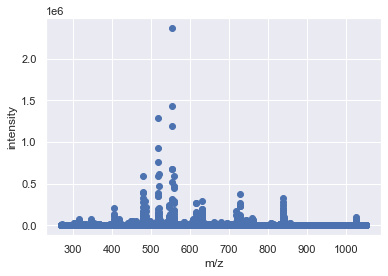

In [4]:
x = df['m/z']
y = df['intensity']

plt.scatter(x,y)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

Normalise intensity

Since in a Mass Spectra the most intense fragment ion is set to 100% and all the other peaks are normalised respectfully to it, we work similarly for our data. 

In order to normalise the data, the method minmax_scale is imported from SciKit-Learn. In addition, notice how the data is now sorted by the intensity.

In [5]:
#normalise the intensity
#Scikit learn version 

my_list = df['intensity']
from sklearn.preprocessing import minmax_scale

def normalise_list_numpy(list_numpy):
    normalised_list = minmax_scale(list_numpy)
    return normalised_list


df['intensity']  = normalise_list_numpy(my_list)

print(df.head(20))

           m/z  intensity
28617  553.800   1.000000
28618  553.811   0.601602
25206  519.303   0.543845
28666  554.304   0.503373
25207  519.313   0.391948
25154  518.786   0.318592
28616  553.790   0.287816
28665  554.294   0.287099
25257  519.811   0.259275
25205  519.293   0.251391
29148  559.270   0.250632
21206  480.253   0.250000
28667  554.314   0.221079
25256  519.801   0.201855
29180  559.601   0.200548
29147  559.260   0.188322
21241  480.588   0.166863
25153  518.776   0.165219
21205  480.243   0.162732
44443  728.369   0.159191


Graph representation of data

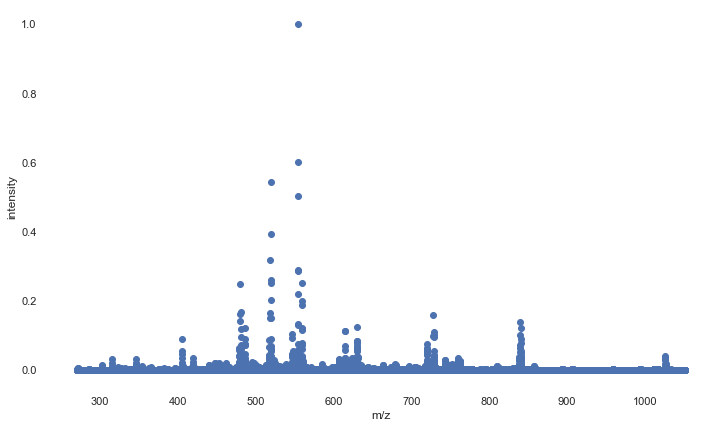

In [6]:
x = df['m/z']
y = df['intensity']

plt.scatter(x,y)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['axes.facecolor'] = 'white'
#plt.grid(b=None)
plt.show()

**important decision:**

Minimum Intensity - Noise threshold

Biological systems carry by definition a high level of background (noise) therefore in order to make the subsequent analysis more straightforward it is useful to set a threshold for minimum intensity. To help this decision, a number of tests that will be discussed more extensively in a later section, took place with results showing that the data points are starting to get clear by setting a minimum intensity at 0.015 or 1.5%.

In [7]:
v = df.iloc[:, 1]
df1 = df[~(v < 0.015)]

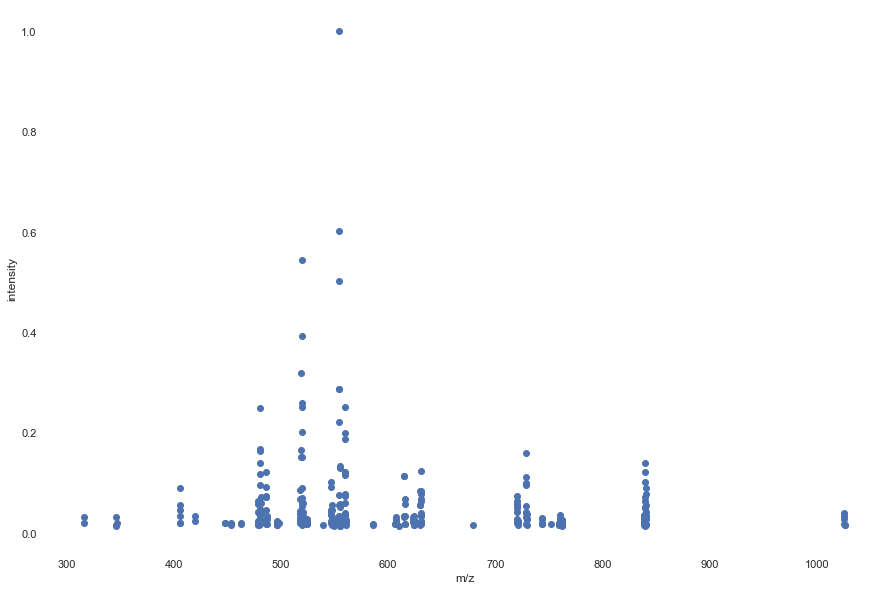

In [8]:
x1 = df1['m/z']
y1 = df1['intensity']
plt.scatter(x1,y1)
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

This is an example of an isotopic window where we notice 17 clear data points; after setting the threshold. The data points look like they are grouped in four sets, which are actually the four different peaks on this window. One can tell by visual inspection that there is a rough 0.5m/z distance between the grouped data points sets/peaks, and as a result, it would be a sensible conclusion that this is a charge state +2 window.


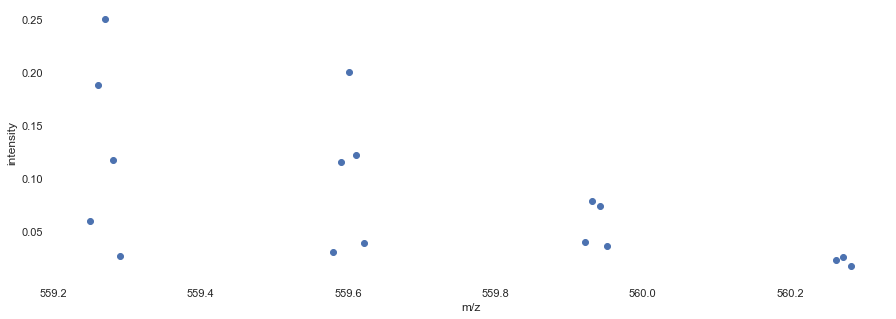

In [9]:
dfexample = df1[(df1['m/z'] > 558) & (df1['m/z'] < 562)]

x = dfexample['m/z']
y = dfexample['intensity']
plt.xlabel('m/z')
plt.ylabel('intensity')
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['axes.facecolor'] = 'white'
plt.scatter(x, y)
plt.show()

## Output 

Prior to every 'new search' which will be described shortly, the data is sorted and saved/exported to a .txt file. In addition, the algorithm creates a directory that includes three more directories, one for each charge state 
Then, each tabular-data-type file as well as its own plot are sorted in the appropriate directory regarding their charge state.
The name of the files, as decided after discussion, describe the first and the last m/z of this specific isotopic window. In that way, one can know which isotopic window and area of the peptide is referring to. 

In [10]:
os.mkdir('data_results')
os.mkdir('data_results/charge_state_2')
os.mkdir('data_results/charge_state_3')
os.mkdir('data_results/charge_state_4')

## Algorithm

The main idea is working in one specific isotopic window per time, extract results and make conclusions on their charge state before moving to the next one.

In each window, the algorithm searches for the highest peak, the one with the highest intensity and sets it as the main one. Then, it starts searching on the right for 0.5 or 0.33 or 0.25 distances. If it finds a peak it keeps a record in a list and now sets the new peak as the main one. The algorithm now does the same for the new main peak until there are no other peaks with the distances requested.
The same process is followed for the left side of the first main peak.

If the algorithm finds 0.5 or 0.33 or 0.25 distances, sets this isotopic window as a charge state 2, 3 and 4 respectively. 


### Identifying Isotopic Windows complication 

The challenge of this approach is the extraction of charge state information from a dataset with many isotopic windows. 

Since the raw data file runs from the smallest m/z to the largest, or left to right, if we consider a plot like the one suggested above, we can see that the start and end of each window is not clearly identified and therefore identifying the peak with the highest intensity is not possible. 
The second column that shows the intensity for each m/z is the one that the algorithm uses to identify the requested peaks, therefore, this is the reason that the normalisation and sorting out the data by intensity ascending order is the very first step in the process. 

Following the intensity normalisation it is easier for the algorithm to determine which is the peak with the highest abundance which is then set as the main peak (point of reference) to begin determining the charge states from. 
As a next step, the algorithm performs the peak searching as described above, sets and names the window as a charge state +2, +3 or +4 and creates two values, max_del and min_del, which are the 0.5 m/z and -0.5 m/z distances respectfully from the highest and lowest values in the m/z-sorted list. These values are also used to set the x-axis limits when creating the plot.

Moreover, these max_del and min_del values are used in order to delete the currently analysed MS-window once the information on charge state and intensities has been extracted, and at the same time to create a new data set excluding the window that we have already examined. 

This step has a key role in the algorithm flow as it can now identify a new highest peak and set it as the new point of reference and follow the same procedure for this newly identified window and peak. 

554.304
1
554.808
2
the charge state is +2 

[553.8, 554.304, 554.808]
[1.0, 0.5033726812816188, 0.13402192242833053]


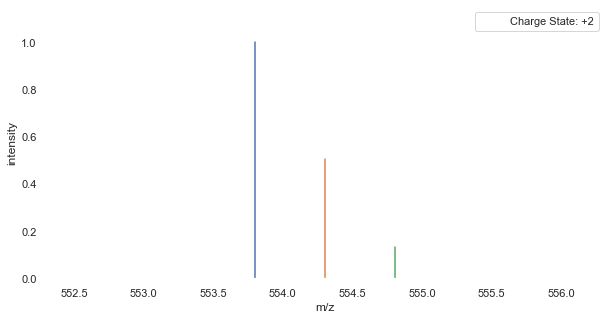

518.786
1
519.811
2
520.309
3
the charge state is +2 

[518.786, 519.303, 519.811, 520.309]
[0.3185919055649241, 0.5438448566610455, 0.25927487352445194, 0.05935919055649241]


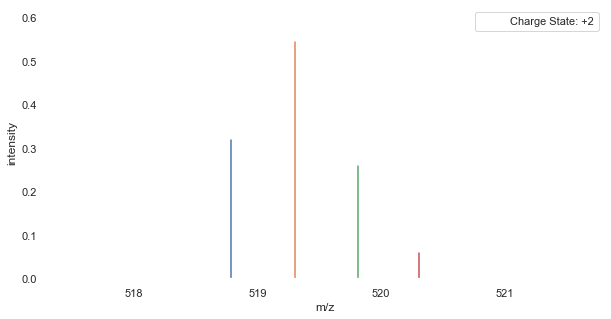

554.808
1
555.302
2
the charge state is +2 

[554.304, 554.808, 555.302]
[0.5033726812816188, 0.13402192242833053, 0.032192242833052276]


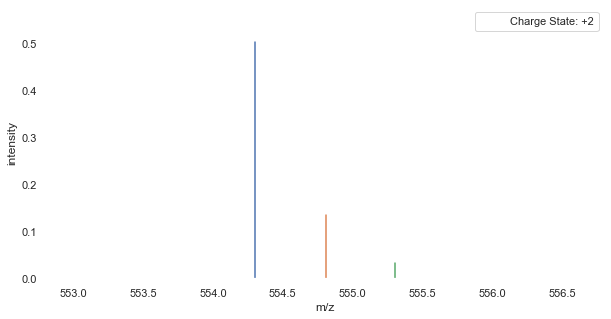

520.309
1
559.601
1
559.931
2
the charge state is +3 

[559.27, 559.601, 559.931]
[0.2506323777403035, 0.20054806070826306, 0.07883642495784147]


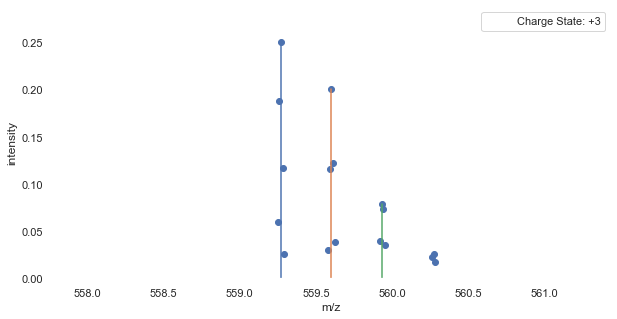

479.908
1
480.588
2
480.923
3
the charge state is +3 

[479.908, 480.253, 480.588, 480.923]
[0.04057335581787521, 0.25, 0.16686340640809444, 0.07103709949409781]


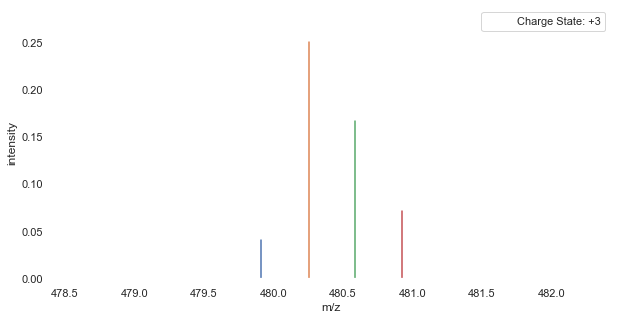

728.876
1
729.371
2
the charge state is +2 

[728.369, 728.876, 729.371]
[0.15919055649241146, 0.09983136593591906, 0.03827150084317032]


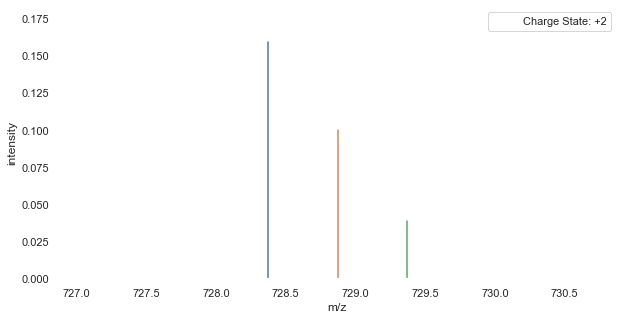

839.763
1
840.433
2
840.762
3
the charge state is +3 

[839.763, 840.091, 840.433, 840.762]
[0.10147554806070826, 0.1393760539629005, 0.08962900505902192, 0.04142495784148398]


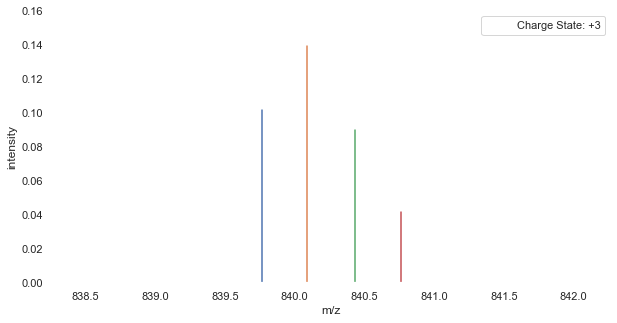

555.302
1
630.073
1
630.577
2
630.83
3
the charge state is +4 

[630.073, 630.325, 630.577, 630.83]
[0.084822934232715, 0.12470489038785834, 0.07765598650927487, 0.03674536256323777]


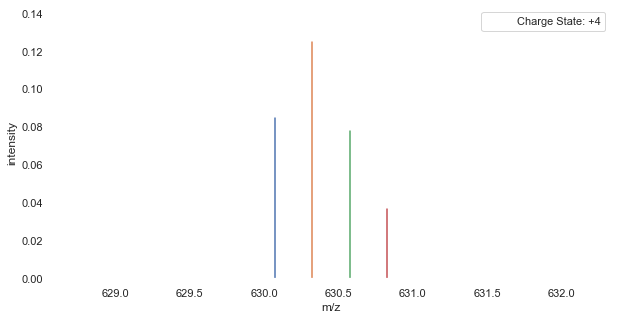

630.83
1
486.252
1
486.58
2
the charge state is +3 

[485.915, 486.252, 486.58]
[0.12133220910623946, 0.09097807757166947, 0.03365514333895447]


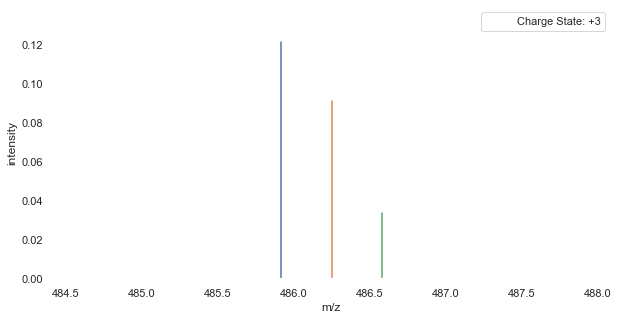

615.341
1
615.839
2
the charge state is +2 

[614.843, 615.341, 615.839]
[0.11403878583473862, 0.06821247892074199, 0.01884485666104553]


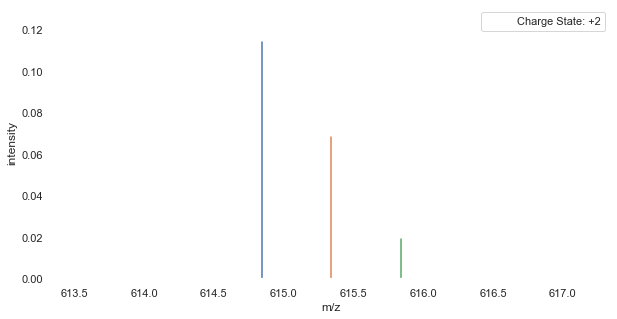

546.784
1
547.284
2
the charge state is +2 

[546.283, 546.784, 547.284]
[0.10282462057335581, 0.04574198988195615, 0.017698145025295108]


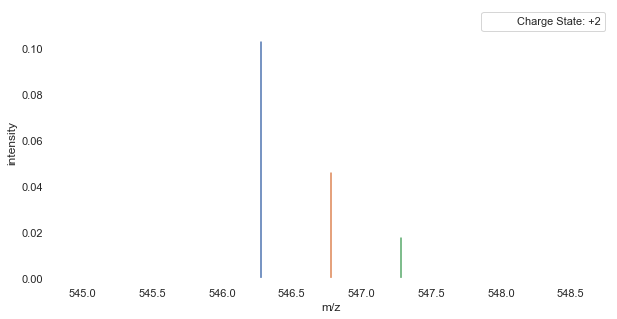

729.371
1
405.736
1
517.782
1
720.378
1
720.882
2
the charge state is +2 

[719.874, 720.378, 720.882]
[0.07470489038785834, 0.06462900505902192, 0.024139966273187183]


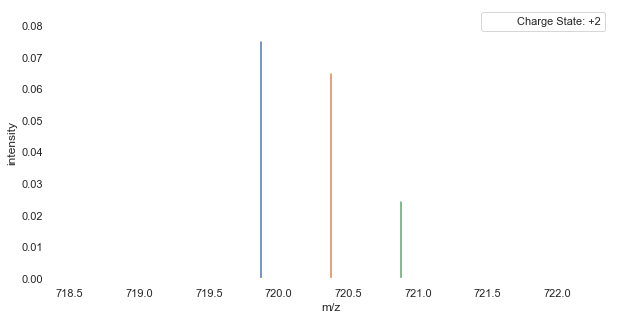

478.924
1
479.258
2
the charge state is +3 

[478.589, 478.924, 479.258]
[0.06488195615514333, 0.041850758853288365, 0.019026138279932544]


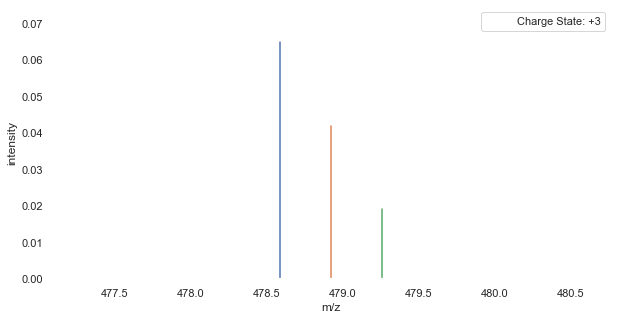

720.882
1
548.316
1
547.284
1
838.902
1
760.031
1
760.705
2
the charge state is +3 

[760.031, 760.368, 760.705]
[0.02900927487352445, 0.03557757166947723, 0.02175379426644182]


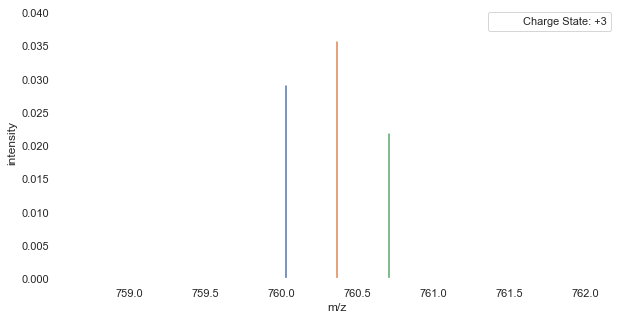

623.546
1
624.048
2
the charge state is +4 

[623.546, 623.797, 624.048]
[0.031724283305227655, 0.034502529510961215, 0.021353288364249576]


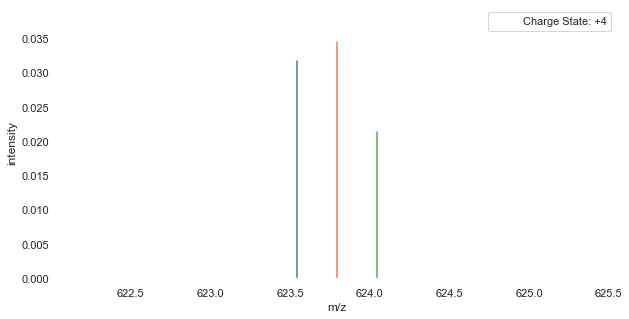

615.839
1
606.792
1
607.276
2
the charge state is +2 

[606.792, 607.276, 607.276]
[0.01803962900505902, 0.03126053962900506, 0.03126053962900506]


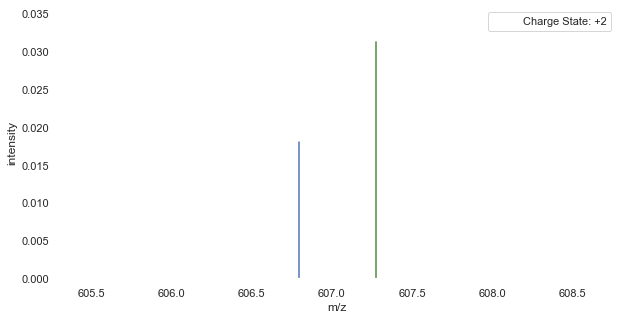

346.526
1
743.878
1
761.861
1
762.356
2
the charge state is +4 

[761.861, 762.103, 762.356]
[0.019304384485666102, 0.02581787521079258, 0.022381956155143337]


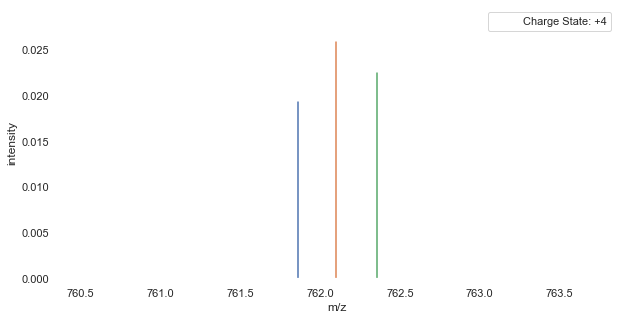

496.25
1
548.971
1
549.309
2
the charge state is +3 

[548.971, 549.309, 549.309]
[0.01951939291736931, 0.023301011804384486, 0.023301011804384486]


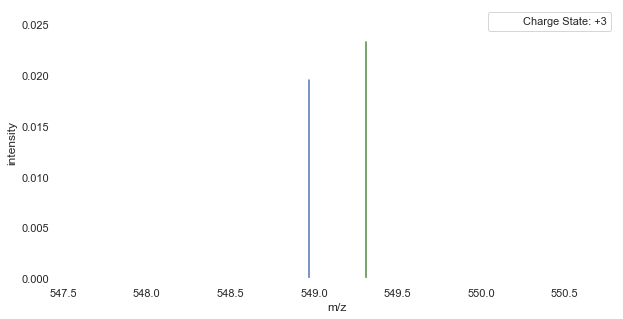

759.344
1
453.256
1
453.59
2
the charge state is +3 

[453.256, 453.59, 453.59]
[0.01767706576728499, 0.020476391231028665, 0.020476391231028665]


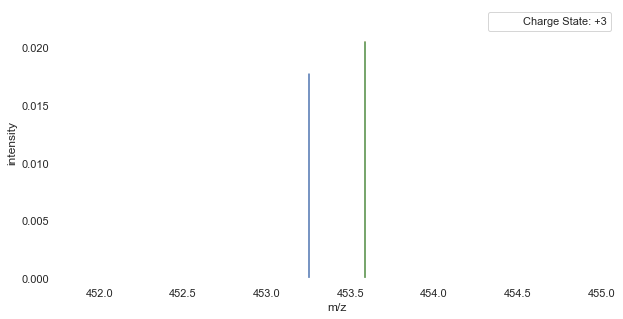

In [11]:
def find_charge_state(a, b):
    total = 0
    new = 0
    peaks = [df1['m/z'].iloc[0],]
#finds the first high intensity with distance ~ a,b 
    for i in df1['m/z']:
        if ((df1['m/z'].iloc[0] - i) > a and (df1['m/z'].iloc[0] - i) < b):
            total += 1 
            new = i
            peaks.append(new)
            print(new)
            print(total)
            break
#trying to find if there's any other distance ~ a,b from the new value 
    for i in df1['m/z']:
        if ((new - i) > a and (new - i) < b):
            total += 1 
            new = i
            peaks.append(new)
            print(new)
            print(total)
            break
             
#finds the first high intensity with distance ~ - a, - b 
    for i in df1['m/z']:
        if ((df1['m/z'].iloc[0] - i) < -a and (df1['m/z'].iloc[0] - i) > -b):
            total += 1 
            new = i
            peaks.append(new)
            print(new)
            print(total)
            break
#trying to find if there's any other distance ~ - a, -b from the new value
    for i in df1['m/z']:
        if ((new - i) < -a and (new - i) > -b):
            total += 1 
            new = i
            peaks.append(new)
            print(new)
            print(total)
            break
    peaks.sort()        

#checking the charge state
    if total >= 2:
        if (a == 0.47 and b == 0.53):
            charge_state = '+2'
            print("the charge state is +2 \n")
        if (a == 0.30 and b == 0.36):
            charge_state = '+3'
            print("the charge state is +3 \n")
        if (a == 0.22 and b == 0.28):
            charge_state = '+4'
            print("the charge state is +4 \n")
    
        print(peaks)
        
        
        peaks_intensity = []
        for i in peaks:
            a = df1['intensity'][df1['m/z']==i].to_list()
            peaks_intensity.append(a[0])
        print(peaks_intensity)
        
        points = list(zip(peaks,peaks_intensity))
        
        
        
        global min_del
        min_del = peaks[0] - 0.5
        #print(min_del)
        
        global max_del
        max_del = peaks[-1] + 0.5
        #print(max_del)
         
        #######################################
        ### plot
        #####################
        
        ax = plt.subplot()
        ax.set_xlabel('m/z')
        ax.set_ylabel('intensity') 
        ## create legend
        extra = Rectangle((0, 0), 0, 0, fc="w", fill=False, edgecolor='none', linewidth=0)
        ax.legend([extra, ' '], ('Charge State: ' + charge_state,))
        
        ## set the axes
        plt.xlim(min_del - 1 , max_del + 1 )
        plt.ylim(0, (max(peaks_intensity)+ 15*max(peaks_intensity)/100))
        
        ## plot peaks 
        for pt in points:
            plt.plot( [pt[0],pt[0]], [0,pt[1]] )
        
        ## plot the rest/noise 
        plt.scatter(x,y)
        
        plt.savefig('sample.png')
        plt.show()
        
        
        ## proergasia gia saving
        df2 = df0[ (df0['m/z'] >= min_del) & (df0['m/z'] <= max_del) ]
        #print(df2['m/z'].size)
        file_start = df2['m/z'].iloc[0]
        file_end = df2['m/z'].iloc[-1]
        
        ######################################
        ### write tabular data in file and ###
        ### move to the right folder       ###        
        f = open('temp_file.txt' , 'w')
        numpy.savetxt(r'data_results/temp_file.txt', df2.values, fmt=['%3.3f', '%.3e'])
        
        if (charge_state == '+2'):
            i=len(os.listdir('data_results/charge_state_2')) + 1
            shutil.move('data_results/temp_file.txt' , 'data_results/charge_state_2/%s_%s.txt' %(file_start, file_end))
            shutil.move('sample.png' , 'data_results/charge_state_2/plot_%s_%s.png'  %(file_start, file_end))
                       
        if (charge_state == '+3'):
            i=len(os.listdir('data_results/charge_state_3')) + 1
            shutil.move('data_results/temp_file.txt' , 'data_results/charge_state_3/%s_%s.txt'  %(file_start, file_end))
            shutil.move('sample.png' , 'data_results/charge_state_3/plot_%s_%s.png'  %(file_start, file_end))

        if (charge_state == '+4'):
            i=len(os.listdir('data_results/charge_state_4')) + 1
            shutil.move('data_results/temp_file.txt' , 'data_results/charge_state_4/%s_%s.txt'  %(file_start, file_end))
            shutil.move('sample.png' , 'data_results/charge_state_4/plot_%s_%s.png'  %(file_start, file_end))

        
        
    else:   #if total<2
        min_del = peaks[0] - 0.5
        max_del = peaks[-1] + 0.5
        
        
vector = list(range(0,1000))        
for i in vector:
    find_charge_state(0.22,0.28)
    find_charge_state(0.47,0.53)
    find_charge_state(0.30,0.36)
    
#df1[~ ((v > min_del) & (v < max_del))]    
    #v = df1.iloc[:, 0]  # v = df.loc[:, df.columns[0]]
    df1 = df1[~( (df1['m/z'] >= min_del) & (df1['m/z'] <= max_del) )].sort_values(['intensity'], 
                                                           ascending = False)
    #print(df['intensity'].iloc[0])
    if df1['intensity'].iloc[0] < 0.016:
        break